In [50]:
from lightning import Trainer
import torch
from torch import nn
import lightning as L
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt


class Classifier(L.LightningModule):
    def __init__(self, in_channels, latent_dims: list, latent_strides: list, latent_kernel_sizes: list,
                 num_classes: int):
        super(Classifier, self).__init__()
        self.latent_dims = latent_dims

        # Encoder layers. Each layer will be a reparameterization layer
        layers = []
        for dim, stride, kernel_size in zip(latent_dims, latent_strides, latent_kernel_sizes):
            layers.append(nn.Conv2d(in_channels, dim, kernel_size, stride))
            in_channels = dim

        self.layers = nn.ModuleList(layers)
        self.fc = nn.Linear(latent_dims[-1], num_classes)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
            x = nn.functional.relu(x)

        # average pooling
        x = nn.functional.avg_pool2d(x, x.size()[2:]).view(x.size(0), -1)
        x = self.fc(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


# def subsample(x: torch.Tensor):
#     assert x.dim() == 3  # (C, H, W)
# 
#     # sample 1/4 of the pixels while preserving order
#     c, h, w = x.size()
#     x = x.view(c, h * w)
#     
#     num_pixels = h * w
#     num_sampled_pixels = num_pixels // 4
#     indices = torch.randperm(num_pixels)[:num_sampled_pixels]
#     # sort the indices to preserve the order
#     indices = indices.sort().values
#     x = x[:, indices]
#     x = x.view(c, h // 2, w // 2)
#     return x

def subsample(x: torch.Tensor, downscale_factor=2, noise_factor=0.05):
    assert x.dim() == 3  # (C, H, W)

    # Downsample using average pooling
    x = F.avg_pool2d(x, kernel_size=downscale_factor)

    # Introduce small random noise
    noise = torch.randn_like(x) * noise_factor
    x = x + noise

    # Clip values to stay within the valid range (e.g., for MNIST this is [0, 1])
    x = torch.clamp(x, 0.0, 1.0)

    return x


def subsample_with_random_stride(x: torch.Tensor, downscale_factor=2, max_offset=1):
    assert x.dim() == 3  # (C, H, W)

    # Randomly shift the starting point of the pooling window
    offset_h = torch.randint(0, max_offset + 1, (1,)).item()
    offset_w = torch.randint(0, max_offset + 1, (1,)).item()

    # Apply padding to ensure pooling still works after shifting
    x = F.pad(x, (offset_w, 0, offset_h, 0), mode='reflect')

    # Downsample using average pooling
    x = F.avg_pool2d(x, kernel_size=downscale_factor, stride=downscale_factor)

    return x


def subsample_with_patch_dropout(x: torch.Tensor, patch_size=2, dropout_prob=0.2):
    assert x.dim() == 3  # (C, H, W)

    # Divide the image into patches and randomly drop some
    c, h, w = x.size()
    patches_per_dim = h // patch_size
    mask = torch.rand(patches_per_dim, patches_per_dim) > dropout_prob

    # Reshape mask to match image resolution
    mask = mask.repeat_interleave(patch_size, dim=0).repeat_interleave(patch_size, dim=1)
    mask = mask.unsqueeze(0).expand(c, -1, -1)  # expand to channel dimension

    # Apply the mask (dropout)
    x = x * mask

    # Downsample after patch dropout
    x = F.avg_pool2d(x, kernel_size=patch_size)

    return x


import torchvision.transforms.functional as TF


def subsample_with_random_transform(x: torch.Tensor, downscale_factor=2):
    assert x.dim() == 3  # (C, H, W)

    # Random affine transformations (rotation, translation, scaling)
    angle = torch.randn(1).item() * 10  # Random rotation (-10 to 10 degrees)
    translate = [torch.randint(-2, 3, (1,)).item(), torch.randint(-2, 3, (1,)).item()]
    scale = 1.0 + torch.randn(1).item() * 0.1  # Scale within [0.9, 1.1]

    # Apply transformations (converted to PIL Image for easy manipulation)
    x_pil = TF.to_pil_image(x.squeeze(0))  # Remove channel dim for MNIST (assumed grayscale)
    x_pil = TF.affine(x_pil, angle=angle, translate=translate, scale=scale, shear=0)

    # Convert back to tensor and add channel dim again
    x = TF.to_tensor(x_pil).unsqueeze(0)

    # Downsample using average pooling
    x = F.avg_pool2d(x, kernel_size=downscale_factor)

    return x


def subsample_with_pixel_swapping(x: torch.Tensor, swap_prob=0.1, downscale_factor=2):
    assert x.dim() == 3  # (C, H, W)

    # Generate a mask for swapping pixels
    c, h, w = x.size()
    swap_mask = torch.rand(h, w) < swap_prob

    # Shift the image by one pixel in a random direction and swap pixels according to the mask
    shift_direction = torch.randint(0, 4, (1,)).item()  # Randomly pick direction: 0=up, 1=down, 2=left, 3=right
    if shift_direction == 0:
        x_shifted = F.pad(x[:, 1:, :], (0, 0, 0, 1), mode='reflect')
    elif shift_direction == 1:
        x_shifted = F.pad(x[:, :-1, :], (0, 0, 1, 0), mode='reflect')
    elif shift_direction == 2:
        x_shifted = F.pad(x[:, :, 1:], (0, 1, 0, 0), mode='reflect')
    else:
        x_shifted = F.pad(x[:, :, :-1], (1, 0, 0, 0), mode='reflect')

    x[swap_mask] = x_shifted[swap_mask]

    # Downsample after swapping
    x = F.avg_pool2d(x, kernel_size=downscale_factor)

    return x


def rnd_subsample_method(x: torch.Tensor):
    methods = [subsample, subsample_with_random_stride, subsample_with_patch_dropout]
    return methods[torch.randint(0, len(methods), (1,)).item()](x)


# Prepare the data
transform = transforms.Compose([transforms.ToTensor(), rnd_subsample_method])
mnist_train = MNIST("../data", train=True, download=True, transform=transform)
mnist_val = MNIST("../data", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=32)
val_loader = DataLoader(mnist_val, batch_size=32)

c = Classifier(
    in_channels=1,
    latent_dims=[32, 64],
    latent_strides=[2, 2],
    latent_kernel_sizes=[3, 3],
    num_classes=10,
)

trainer = Trainer(max_epochs=5, fast_dev_run=False)
trainer.fit(c, train_loader, val_loader)

# Evaluate the model
results = trainer.test(c, val_loader)

# Print accuracy
print(f"Test Accuracy: {results[0]['test_acc']:.4f}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type       | Params
--------------------------------------
0 | layers | ModuleList | 18.8 K
1 | fc     | Linear     | 650   
--------------------------------------
19.5 K    Trainable params
0         Non-trainable params
19.5 K    Total params
0.078     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.933899998664856     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 0.9339


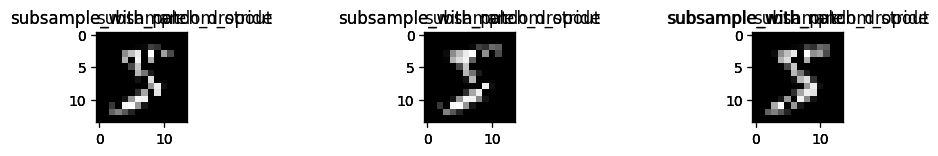

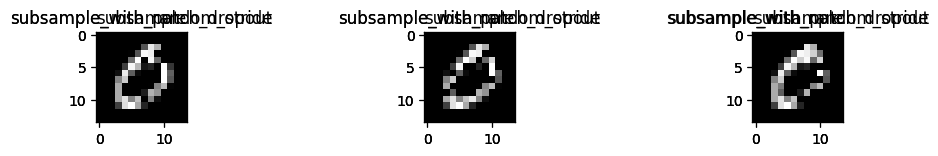

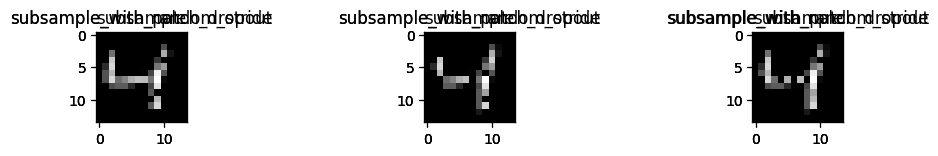

In [40]:
# dispay the different subsampling methods, same image repeated 3 times
for i in range(3):
    fig = plt.figure(figsize=(12, 4))
    x, y = mnist_train[i]

    for method in [subsample, subsample_with_random_stride, subsample_with_patch_dropout]:
        for col in range(3):
            x_subsample = method(x)
            ax = fig.add_subplot(3, 3, 3 * i + col + 1)
            ax.imshow(x_subsample.squeeze().numpy(), cmap='gray')
            ax.set_title(method.__name__)



